# Sentiment Analysis - Hotel Review  
* Bidirectional GRU
* Bidirectional LSTM
* SimpleRNN
* Neural Network

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve
import tensorflow as tf
from tensorflow import keras

from keras.layers import Embedding, Dense, LSTM, Bidirectional
from keras.layers import Flatten, GRU, Dropout, SimpleRNN,SpatialDropout1D, GlobalAveragePooling1D
from keras import Input, Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import plot_model

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Read Data
* Data Source: [Trip Advisor Hotel Review](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews) 

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv',engine='python')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.shape

(20491, 2)

In [5]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Label Review Rating


*   0 if rating is 1 or 2 or 3
*   1 if rating is 4 or 5

In [6]:
df['label'] = np.array(df['Rating'].apply(lambda x: 1 if x > 3 else 0))
df.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


## Preprocessing Review Text


*   remove integer values
*   breakdown to words by space delimiter 
*   remove stopwords using nltk library



In [7]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess(text):
    txt = text.lower()
    txt = re.sub(r'[^a-zA-Z]',' ',txt)
    txt = txt.split()
    txt = ' '.join([w for w in txt if not w.lower().strip() in stop_words])
    return txt

In [9]:
df['Review'] = df['Review'].apply(preprocess)


## Training and Testing Data Split

> Split data into train and test datasets with equal proportion of label.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'].values,df['label'].values,
                                                    test_size=0.2, random_state=1,stratify=df['label'].values)

## Tokenization

*   convert to lower case (default)
*   remove punctuation
*   integer encoding to word - map each word with unique index for each word with most common as 1 to least common xxx
*   sequence encoding to review
*   NOTE: require data to be str format

AVOID Data Leakage
*  build tokenizer using only training data





In [11]:
NWORDS = 10000
tknz = Tokenizer(num_words=NWORDS,oov_token ="_OOV")
tknz.fit_on_texts(X_train)

train_seq = tknz.texts_to_sequences(X_train)
test_seq = tknz.texts_to_sequences(X_test)

In [12]:
print(len(tknz.word_index))

43674


Padding
*   get the length of longest review text 
*   set all sequences to a uniform length with the longest review length by filling in with 0 
*   padding flag 'pre': pad 0 in the beginning
*   padding flag 'post': pad 0 in the end



In [13]:
MAX_SEQ_LEN =np.max(list(map(lambda x: len(x), train_seq)))+1
MAX_SEQ_LEN

1890

In [14]:
pad_train_seq = pad_sequences(train_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')
pad_test_seq = pad_sequences(test_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')


## Build Models & Performance Evaluation

*   Bidirectional GRU
*   Bidirectional LSTM
*   SimpleRNN
*   Neural Network


In [15]:
EMBED_DIM = 32
BATCH_SIZE = 1000
EPOCH = 30

In [16]:
def show_model_summary(model):
  print()
  print(model.summary())
  print()

In [17]:
#@title
def build_BiGRU(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS+1, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(32,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', 
                           tf.keras.metrics.AUC(name='AUC'),
                           keras.metrics.AUC(name='PRC', curve='PR')])
  
  return model

In [18]:
def fit_model(model, model_name):
  history = model.fit(pad_train_seq,y_train,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,epochs=EPOCH,
                    verbose=1,
                    callbacks=[
                            EarlyStopping(
                            monitor='val_PRC',
                            patience=3,
                            mode = 'max',
                            restore_best_weights=True
                        )
                        
                    ]
                   )
  model.save(model_name)
  print(pd.DataFrame(model.history.history))
  return history

In [19]:
def plot_metrics(history):
  metrics = ['loss', 'PRC', 'AUC', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'AUC':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1890, 32)          320032    
                                                                 
 dropout (Dropout)           (None, 1890, 32)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1890, 64)         12672     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1890, 64)          0         
                                                                 
 flatten (Flatten)           (None, 120960)            0         
                                                                 
 dense (Dense)               (None, 1)                 120961    
                                                       

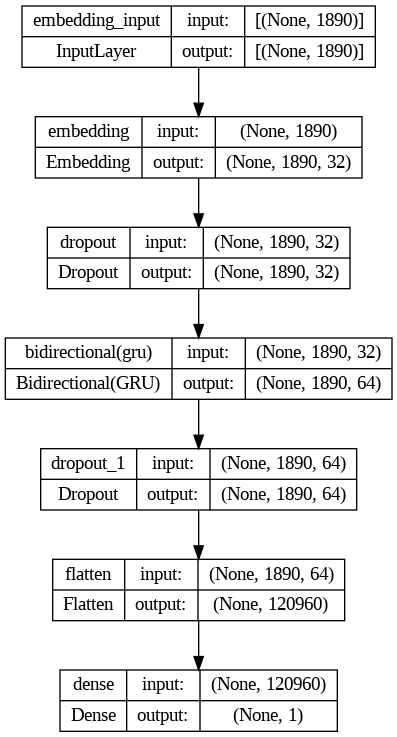

In [20]:
grumodel = build_BiGRU(EMBED_DIM)
show_model_summary(grumodel)
plot_model(grumodel,show_shapes=True)

### Model Training and Model Evaluation

Epoch 1/30
14/14 [==============================] - 16s 448ms/step - loss: 0.6078 - accuracy: 0.7046 - AUC: 0.5133 - PRC: 0.7433 - val_loss: 0.5621 - val_accuracy: 0.7505 - val_AUC: 0.6273 - val_PRC: 0.8287
Epoch 2/30
14/14 [==============================] - 5s 353ms/step - loss: 0.5677 - accuracy: 0.7326 - AUC: 0.6130 - PRC: 0.8035 - val_loss: 0.5290 - val_accuracy: 0.7505 - val_AUC: 0.7392 - val_PRC: 0.8899
Epoch 3/30
14/14 [==============================] - 5s 366ms/step - loss: 0.5165 - accuracy: 0.7400 - AUC: 0.7899 - PRC: 0.9068 - val_loss: 0.4426 - val_accuracy: 0.7899 - val_AUC: 0.8678 - val_PRC: 0.9499
Epoch 4/30
14/14 [==============================] - 5s 359ms/step - loss: 0.3859 - accuracy: 0.8329 - AUC: 0.9040 - PRC: 0.9595 - val_loss: 0.2970 - val_accuracy: 0.8780 - val_AUC: 0.9279 - val_PRC: 0.9710
Epoch 5/30
14/14 [==============================] - 5s 356ms/step - loss: 0.2727 - accuracy: 0.8921 - AUC: 0.9355 - PRC: 0.9715 - val_loss: 0.2544 - val_accuracy: 0.8987 - val

[0.2949957251548767,
 0.8850939273834229,
 0.9390677213668823,
 0.9730156064033508]

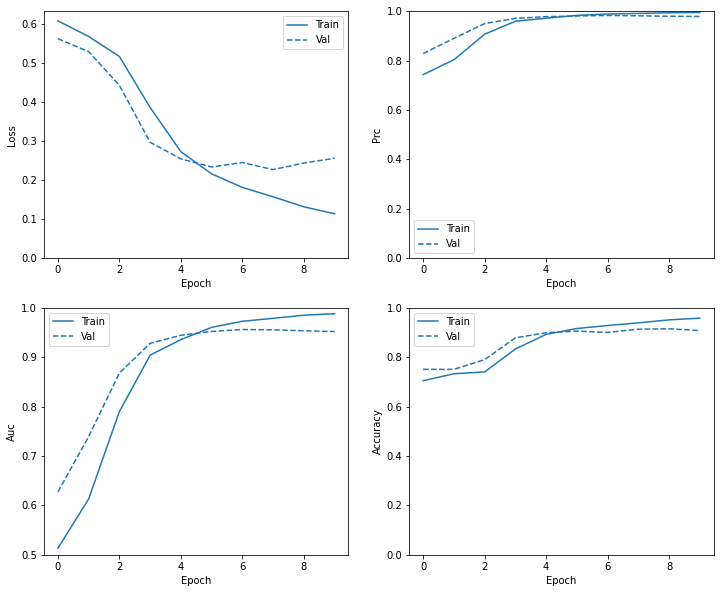

In [21]:
gruhistory = fit_model(grumodel,'./saved_model/grumodel1.h5')
plot_metrics(gruhistory)
gru_results = grumodel.evaluate(pad_test_seq,y_test,verbose=1)
gru_results

In [22]:
def build_LSTM(embedding_dim):
  model=Sequential()
  model.add(Embedding(NWORDS+1,embedding_dim,input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(32,return_sequences=True,recurrent_dropout=0.2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         tf.keras.metrics.AUC(name='AUC'),
                         keras.metrics.AUC(name='PRC', curve='PR')])
  return model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1890, 32)          320032    
                                                                 
 dropout_2 (Dropout)         (None, 1890, 32)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1890, 64)         16640     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 1890, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 120960)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 120961    
                                                     

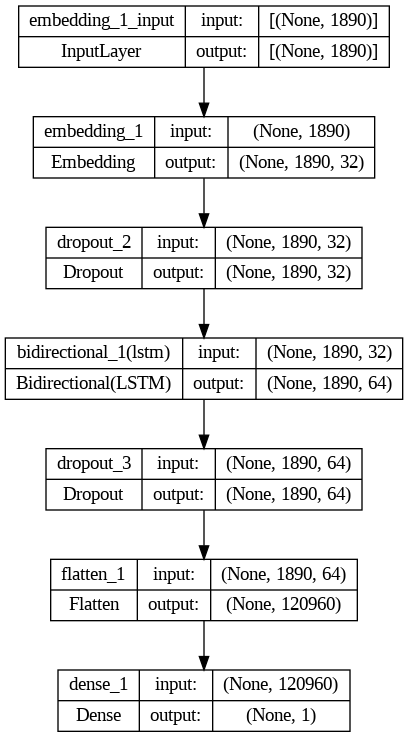

In [23]:
lstmmodel = build_LSTM(EMBED_DIM)
show_model_summary(lstmmodel)
plot_model(lstmmodel,show_shapes=True)

Epoch 1/30
14/14 [==============================] - 202s 14s/step - loss: 0.5945 - accuracy: 0.6992 - AUC: 0.5222 - PRC: 0.7444 - val_loss: 0.5572 - val_accuracy: 0.7502 - val_AUC: 0.6490 - val_PRC: 0.8395
Epoch 2/30
14/14 [==============================] - 200s 14s/step - loss: 0.5567 - accuracy: 0.7324 - AUC: 0.6888 - PRC: 0.8521 - val_loss: 0.5027 - val_accuracy: 0.7536 - val_AUC: 0.8116 - val_PRC: 0.9242
Epoch 3/30
14/14 [==============================] - 198s 14s/step - loss: 0.4507 - accuracy: 0.7865 - AUC: 0.8604 - PRC: 0.9378 - val_loss: 0.3034 - val_accuracy: 0.8670 - val_AUC: 0.9271 - val_PRC: 0.9718
Epoch 4/30
14/14 [==============================] - 199s 14s/step - loss: 0.2849 - accuracy: 0.8871 - AUC: 0.9289 - PRC: 0.9677 - val_loss: 0.2449 - val_accuracy: 0.8991 - val_AUC: 0.9472 - val_PRC: 0.9786
Epoch 5/30
14/14 [==============================] - 200s 14s/step - loss: 0.2216 - accuracy: 0.9112 - AUC: 0.9590 - PRC: 0.9830 - val_loss: 0.2261 - val_accuracy: 0.9076 - val_

[0.27389153838157654,
 0.8943644762039185,
 0.9403197169303894,
 0.9737706184387207]

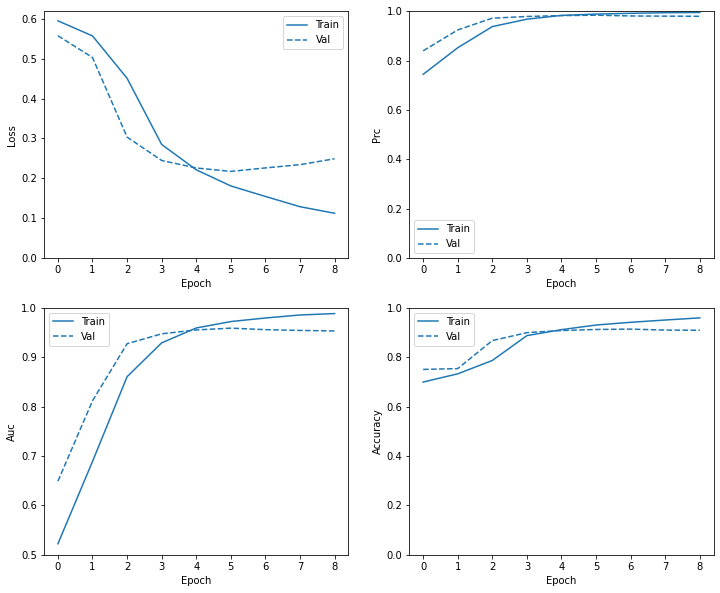

In [24]:
lstmhistory = fit_model(lstmmodel,'./saved_model/lstmmodel1.h5')
plot_metrics(lstmhistory)
lstm_results = lstmmodel.evaluate(pad_test_seq,y_test,verbose=1)
lstm_results 

In [25]:
def build_RNN(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS+1,
                      output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(SimpleRNN(32, activation='relu',name="RNN_Layer"))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid', name="Output"))

  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         tf.keras.metrics.AUC(name='AUC'),
                         keras.metrics.AUC(name='PRC', curve='PR')])
  
  
  return model


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1890, 32)          320032    
                                                                 
 dropout_4 (Dropout)         (None, 1890, 32)          0         
                                                                 
 RNN_Layer (SimpleRNN)       (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 322,145
Trainable params: 322,145
Non-t

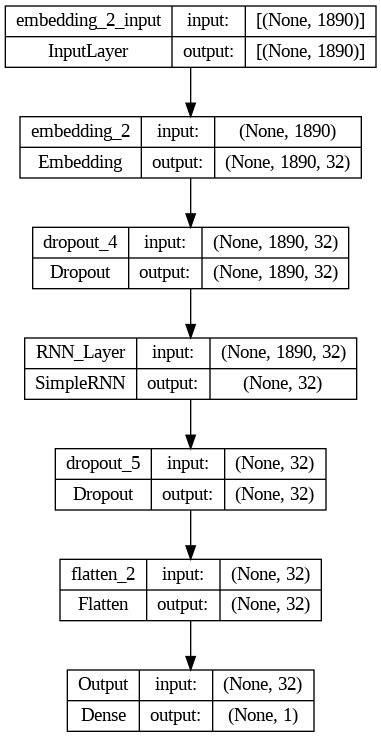

In [26]:
rnnmodel = build_RNN(EMBED_DIM)

show_model_summary(rnnmodel)
plot_model(rnnmodel,show_shapes=True)

Epoch 1/30
14/14 [==============================] - 34s 2s/step - loss: 0.6385 - accuracy: 0.7068 - AUC: 0.4975 - PRC: 0.7310 - val_loss: 0.5640 - val_accuracy: 0.7511 - val_AUC: 0.5000 - val_PRC: 0.7511
Epoch 2/30
14/14 [==============================] - 30s 2s/step - loss: 0.5920 - accuracy: 0.7329 - AUC: 0.4955 - PRC: 0.7300 - val_loss: 0.5703 - val_accuracy: 0.7511 - val_AUC: 0.5000 - val_PRC: 0.7511
Epoch 3/30
14/14 [==============================] - 31s 2s/step - loss: 0.5904 - accuracy: 0.7328 - AUC: 0.4872 - PRC: 0.7253 - val_loss: 0.5652 - val_accuracy: 0.7511 - val_AUC: 0.5000 - val_PRC: 0.7511
Epoch 4/30
14/14 [==============================] - 30s 2s/step - loss: 0.5842 - accuracy: 0.7328 - AUC: 0.5169 - PRC: 0.7391 - val_loss: 0.5624 - val_accuracy: 0.7511 - val_AUC: 0.5000 - val_PRC: 0.7511
       loss  accuracy       AUC       PRC  val_loss  val_accuracy  val_AUC  \
0  0.638519  0.706780  0.497500  0.731030  0.563991      0.751144      0.5   
1  0.591952  0.732937  0.495

[0.5827670693397522, 0.7365211248397827, 0.5, 0.7365211844444275]

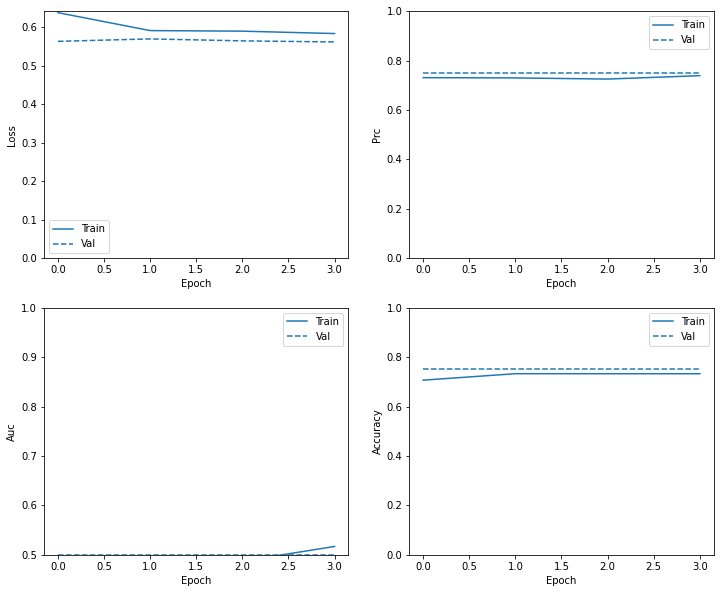

In [27]:
rnnhistory = fit_model(rnnmodel,'./saved_model/rnnmodel1.h5')
plot_metrics(rnnhistory)
rnn_results = rnnmodel.evaluate(pad_test_seq,y_test,verbose=1)
rnn_results 

In [28]:
def build_NN(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS+1,
                      output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN
                      ))
  model.add(Dropout(0.5))
  model.add(Dense(32,activation='relu'))
  model.add(Dropout(0.25))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         tf.keras.metrics.AUC(name='AUC'),
                         keras.metrics.AUC(name='PRC', curve='PR')])


  return model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1890, 32)          320032    
                                                                 
 dropout_6 (Dropout)         (None, 1890, 32)          0         
                                                                 
 dense_2 (Dense)             (None, 1890, 32)          1056      
                                                                 
 dropout_7 (Dropout)         (None, 1890, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                     

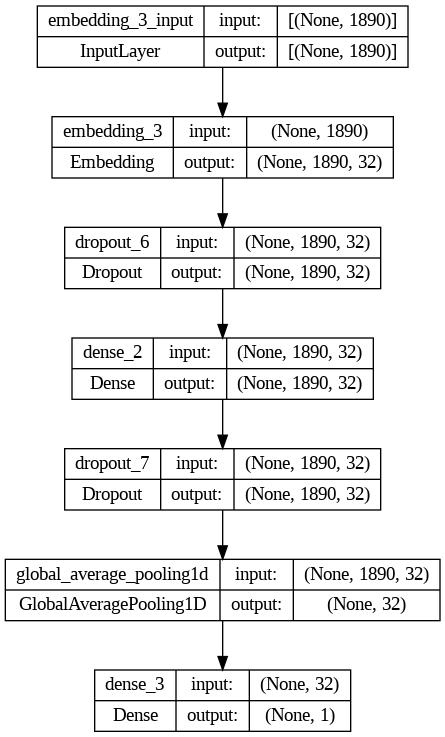

In [29]:
nnmodel = build_NN(EMBED_DIM)
show_model_summary(nnmodel)
plot_model(nnmodel,show_shapes=True)

Epoch 1/30
14/14 [==============================] - 2s 106ms/step - loss: 0.6838 - accuracy: 0.6631 - AUC: 0.5043 - PRC: 0.7347 - val_loss: 0.6660 - val_accuracy: 0.7511 - val_AUC: 0.5070 - val_PRC: 0.7538
Epoch 2/30
14/14 [==============================] - 1s 73ms/step - loss: 0.6539 - accuracy: 0.7329 - AUC: 0.5068 - PRC: 0.7367 - val_loss: 0.6307 - val_accuracy: 0.7511 - val_AUC: 0.5145 - val_PRC: 0.7669
Epoch 3/30
14/14 [==============================] - 1s 72ms/step - loss: 0.6208 - accuracy: 0.7329 - AUC: 0.5052 - PRC: 0.7393 - val_loss: 0.5927 - val_accuracy: 0.7511 - val_AUC: 0.5861 - val_PRC: 0.7963
Epoch 4/30
14/14 [==============================] - 1s 72ms/step - loss: 0.5911 - accuracy: 0.7329 - AUC: 0.5268 - PRC: 0.7553 - val_loss: 0.5663 - val_accuracy: 0.7511 - val_AUC: 0.5850 - val_PRC: 0.8032
Epoch 5/30
14/14 [==============================] - 1s 74ms/step - loss: 0.5801 - accuracy: 0.7329 - AUC: 0.5170 - PRC: 0.7494 - val_loss: 0.5594 - val_accuracy: 0.7511 - val_AUC:

[0.5235841870307922, 0.746767520904541, 0.7932648658752441, 0.9132048487663269]

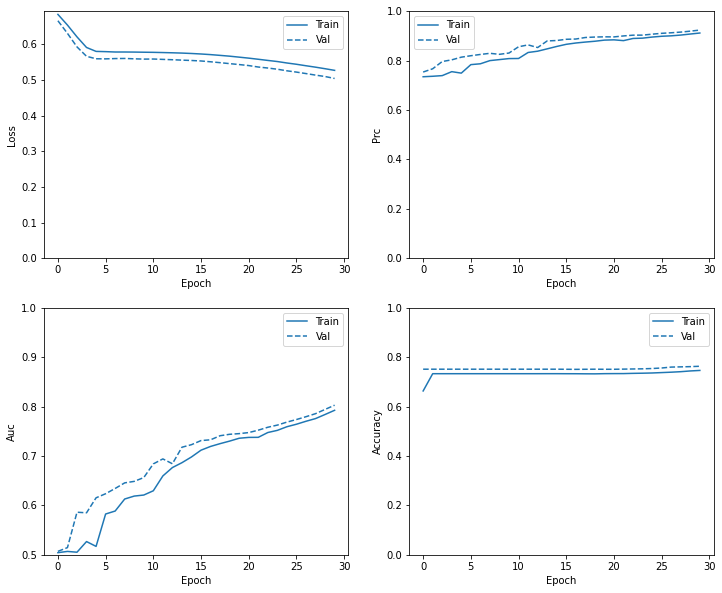

In [30]:
nnhistory = fit_model(nnmodel,'./saved_model/nnmodel1.h5')
plot_metrics(nnhistory)
nn_restuls = nnmodel.evaluate(pad_test_seq,y_test,verbose=1)
nn_restuls

In [31]:
print("Bidirectional GRU: ", gru_results)
print("Bidirectional LSTM: ", lstm_results)
print("SimpleRNN: ", rnn_results)
print("Neural Network: ", nn_restuls)

Bidirectional GRU:  [0.2949957251548767, 0.8850939273834229, 0.9390677213668823, 0.9730156064033508]
Bidirectional LSTM:  [0.27389153838157654, 0.8943644762039185, 0.9403197169303894, 0.9737706184387207]
SimpleRNN:  [0.5827670693397522, 0.7365211248397827, 0.5, 0.7365211844444275]
Neural Network:  [0.5235841870307922, 0.746767520904541, 0.7932648658752441, 0.9132048487663269]


In [32]:
def test_eval(clf_model, testX, testy):
    # Test set prediction
    y_pred=clf_model.predict(testX)
    y_predict = []
    for p in y_pred:
        if p > 0.5:
            y_predict.append(1)
        else:
            y_predict.append(0)
    print('Confusion Matrix')
    print('='*60)
    cm = confusion_matrix(testy,y_predict)
    print(cm,"\n")
    print('Classification Report')
    print('='*60)
    cr = classification_report(testy,y_predict)
    print(cr,"\n")
    
    return cm,cr,y_predict

def plot_cmatrix(cmatrix, name):
    fig = px.imshow(cmatrix,color_continuous_scale=[[0.0, 'peachpuff'], 
                                          [0.5, 'lime'], 
                                          [1.0, 'green']])

    fig.update_layout(
        title = 'Confusion Matrix ('+ name + ')', title_x=0.5,
        xaxis_title="Predicted Label", yaxis_title="Actual Label", 
        height=400,
        width=400,
        xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1),
        yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1)
    )
    for i in range(len(cmatrix)):
        for j in range(len(cmatrix[0])):
            fig.add_annotation(
                x=j,
                y=i,
                text=str(cmatrix[i,j]),
                showarrow=False,
                font_size=9, font_color='black'
            )

    fig.show()


cm1,cr1,_  = test_eval(grumodel,pad_test_seq,y_test)
cm2,cr2,_  = test_eval(lstmmodel,pad_test_seq,y_test)
cm3,cr3,_  = test_eval(rnnmodel,pad_test_seq,y_test)
cm4,cr4,_  = test_eval(nnmodel,pad_test_seq,y_test)

plot_cmatrix(cm1, name='Bidirectional GRU')
plot_cmatrix(cm2, name='Bidirectional LSTM')
plot_cmatrix(cm3, name='SimpleRNN')
plot_cmatrix(cm4, name='Neural Network')

129/129 [==============================] - 6s 43ms/step
Confusion Matrix
[[ 890  190]
 [ 281 2738]] 

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1080
           1       0.94      0.91      0.92      3019

    accuracy                           0.89      4099
   macro avg       0.85      0.87      0.86      4099
weighted avg       0.89      0.89      0.89      4099
 

129/129 [==============================] - 142s 1s/step
Confusion Matrix
[[ 807  273]
 [ 160 2859]] 

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1080
           1       0.91      0.95      0.93      3019

    accuracy                           0.89      4099
   macro avg       0.87      0.85      0.86      4099
weighted avg       0.89      0.89      0.89      4099
 

129/129 [==============================] - 27s 210ms/step
Confusion Matrix
[[   0 1080]
 [   0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Confusion Matrix
[[  89  991]
 [  47 2972]] 

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.08      0.15      1080
           1       0.75      0.98      0.85      3019

    accuracy                           0.75      4099
   macro avg       0.70      0.53      0.50      4099
weighted avg       0.72      0.75      0.67      4099
 



In [33]:
precision1, recall1, _ = precision_recall_curve(y_test, grumodel.predict(pad_test_seq))
precision2, recall2, _ = precision_recall_curve(y_test, lstmmodel.predict(pad_test_seq))
precision3, recall3, _ = precision_recall_curve(y_test, rnnmodel.predict(pad_test_seq))
precision4, recall4, _ = precision_recall_curve(y_test, nnmodel.predict(pad_test_seq))

129/129 [==============================] - 0s 3ms/step


### Test Data - Performance Evaluation Summary 
* Since this is an imbalance data problem - PRC and F1-score metrics are used to evaluate the performance of these 4 algorithms.  
* Bidirectional LSTM achieves the best performance scores. However - bidirectional GRU achieves comparable results with faster computational time.  
   

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=recall1,y=precision1,mode='lines',name='Bidirectional GRU'))
fig.add_trace(go.Scatter(x=recall2,y=precision2,mode='lines',name='Bidirectional LSTM'))
fig.add_trace(go.Scatter(x=recall3,y=precision3,mode='lines',name='SimpleRNN'))
fig.add_trace(go.Scatter(x=recall4,y=precision4,mode='lines',name='Neural Network'))
fig.update_layout(title='Precision-Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision', title_x = 0.5,
                   width = 800, height=450,
                 )
fig.show()